#### ADS 509
#### Assignment 2
#### Abby Tan
#### GitHub Link: https://github.com/Abby-Tan/ADS509_Assignment_5

# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [108]:
# add any additional libaries you need here
import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\abby0\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [241]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

#import gensim
#import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel,LdaMulticore, Phrases 
#from gensim.models.phrases import Phraser 
#from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

In [242]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [243]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [244]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [245]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

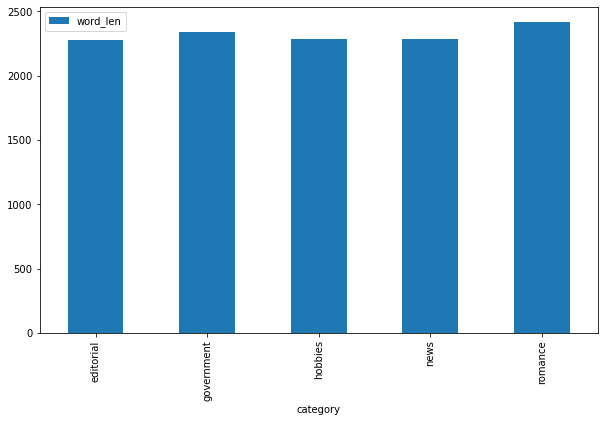

In [246]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [247]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

(166, 4941)

In [293]:
pd.DataFrame(count_text_vectors.toarray()).head(3)

,0,1,2,3,4,5,6,7,8,9,...,4931,4932,4933,4934,4935,4936,4937,4938,4939,4940
0,0,3,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,3,0,0,0,1,0,1,0,0,...,0,0,0,3,0,0,0,0,2,0
2,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0


In [319]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

In [313]:
pd.DataFrame(tfidf_text_vectors.toarray()).head(3)

,0,1,2,3,4,5,6,7,8,9,...,4931,4932,4933,4934,4935,4936,4937,4938,4939,4940
0,0.0,0.046852,0.0,0.000000,0.0,0.000000,0.0,0.023450,0.0,0.019456,...,0.0,0.0,0.0,0.016895,0.000000,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.040107,0.0,0.000000,0.0,0.015896,0.0,0.020074,0.0,0.000000,...,0.0,0.0,0.0,0.043389,0.000000,0.0,0.0,0.0,0.062348,0.0
2,0.0,0.000000,0.0,0.041794,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.034956,0.0,0.0,0.0,0.000000,0.0


Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The count_text_vectors data frame holds the count of words in each article, and the tfidf_text_vectors data frame holds the weights of each  word in the model. 

Reference: https://scikit-learn.org/stable/modules/feature_extraction.html

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [163]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [164]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.40)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.64)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.01)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [170]:
# Your code here

In [271]:
nmf_W_text_matrix = pd.DataFrame(W_text_matrix)
nmf_W_text_matrix.columns = ['Topic 00', 'Topic 01', 'Topic 02', 'Topic 03', 'Topic 04']
nmf_W_text_matrix['Topic'] = nmf_W_text_matrix.idxmax(axis=1)

In [272]:
nmf_topic = pd.concat([nmf_W_text_matrix[['Topic']], df[['category']]], axis=1 )

In [273]:
nmf_topic.head(3)

,Topic,category
0,Topic 02,editorial
1,Topic 00,editorial
2,Topic 00,editorial


In [274]:
nmf_topic.groupby('Topic')['category'].value_counts()

Topic     category  
Topic 00  editorial     20
          news           8
          government     4
Topic 01  romance       29
          hobbies        8
          editorial      4
Topic 02  government    26
          hobbies       26
          news          11
          editorial      2
Topic 03  news          17
          hobbies        1
Topic 04  news           8
          editorial      1
          hobbies        1
Name: category, dtype: int64

In [303]:
nmf_topic.groupby('category')['Topic'].value_counts()

category    Topic   
editorial   Topic 00    20
            Topic 01     4
            Topic 02     2
            Topic 04     1
government  Topic 02    26
            Topic 00     4
hobbies     Topic 02    26
            Topic 01     8
            Topic 03     1
            Topic 04     1
news        Topic 03    17
            Topic 02    11
            Topic 00     8
            Topic 04     8
romance     Topic 01    29
Name: Topic, dtype: int64

In [302]:
nmf_topic['category'].value_counts()

news          44
hobbies       36
government    30
romance       29
editorial     27
Name: category, dtype: int64

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: From the NMF model, Topic 00 and Topic 01 seem to be agreed with the original categories. There is a total of 27 articles in the Editorial category, and 20 records are labeled in Topic 00. A total of 29 articles in Romance, and 29 records are labeled in Topic 01

The rest of the topics seem to be ambiguous. Topic 02 has 26 Governments and 26 Hobbits. From the keywords, Government seems to be more reasonable for Topic 02. Also, Topic 03 doesn't seem to be News from the keywords. Topic 04 seems to be Hobbit, but only one record from Hobbit is labeled in this topic.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [304]:
# Your code here
svd_text_model = TruncatedSVD(n_components=5, n_iter=7, random_state=314)
svd_W_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
svd_H_text_matrix = svd_text_model.components_

In [309]:
svd_W_text_matrix = pd.DataFrame(svd_W_text_matrix)
svd_W_text_matrix.columns = ['Topic 00', 'Topic 01', 'Topic 02', 'Topic 03', 'Topic 04']
svd_W_text_matrix['Topic'] = svd_W_text_matrix.idxmax(axis=1)

In [277]:
svd_topic = pd.concat([svd_W_text_matrix[['Topic']], df[['category']]], axis=1 )
svd_topic.head(3)

,Topic,category
0,Topic 00,editorial
1,Topic 00,editorial
2,Topic 00,editorial


In [278]:
svd_topic.groupby('Topic')['category'].value_counts()

Topic     category  
Topic 00  hobbies       36
          news          34
          government    30
          editorial     27
          romance       21
Topic 01  romance        8
Topic 03  news           3
Topic 04  news           7
Name: category, dtype: int64

Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The LSA model has most of the records fall under Topic 1. Also, Topic 03 and 04 are only in the category of News. The model seems not performing well in terms of comparing to the original categories.  

In [197]:
# call display_topics on your model

In [279]:
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.13)
  mr (1.72)
  said (1.04)
  kennedy (0.81)
  laos (0.77)

Topic 03
  mrs (29.43)
  club (6.54)
  game (6.11)
  jr (5.61)
  dallas (5.23)

Topic 04
  game (4.43)
  league (3.18)
  baseball (3.15)
  ball (3.01)
  team (2.88)


Q: What is your interpretation of the display topics output? 

A: The keywords seem to be similar in the first three topics and similar in the last 2 topics. The words in Topic 03 and 04 don't seem to be related with the category of News. 

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [321]:
# Fit your LDA model here
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=314)
lda_W_text_matrix = lda_text_model.fit_transform(count_text_vectors)
lda_H_svd_matrix = lda_text_model.components_

In [322]:
lda_W_text_matrix = pd.DataFrame(lda_W_text_matrix)
lda_W_text_matrix.columns = ['Topic 00', 'Topic 01', 'Topic 02', 'Topic 03', 'Topic 04']
lda_W_text_matrix['Topic'] = lda_W_text_matrix.idxmax(axis=1)

In [323]:
lda_topic = pd.concat([lda_W_text_matrix[['Topic']], df[['category']]], axis=1 )
lda_topic.head(3)

,Topic,category
0,Topic 02,editorial
1,Topic 02,editorial
2,Topic 02,editorial


In [324]:
lda_topic.groupby('Topic')['catRregory'].value_counts()

Topic     category  
Topic 00  romance       28
          hobbies       11
          news           4
          editorial      3
          government     1
Topic 01  government    12
          hobbies        9
          news           3
          editorial      1
Topic 02  news          32
          editorial     21
          government     3
          hobbies        2
          romance        1
Topic 03  hobbies        8
          government     4
          news           3
          editorial      2
Topic 04  government    10
          hobbies        6
          news           2
Name: category, dtype: int64

In [328]:
lda_topic.groupby('category')['Topic'].value_counts()

category    Topic   
editorial   Topic 02    21
            Topic 00     3
            Topic 03     2
            Topic 01     1
government  Topic 01    12
            Topic 04    10
            Topic 03     4
            Topic 02     3
            Topic 00     1
hobbies     Topic 00    11
            Topic 01     9
            Topic 03     8
            Topic 04     6
            Topic 02     2
news        Topic 02    32
            Topic 00     4
            Topic 01     3
            Topic 03     3
            Topic 04     2
romance     Topic 00    28
            Topic 02     1
Name: Topic, dtype: int64

In [325]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: The categories of Romance and Hobbies can have many similar words, as well as News and Editorial can have the same situation.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: Compare to the original categories, all the categories are not unique to the Topic. Most of the Romance and Hobbies articles are grouped on the same topic, and most of the  News and Editorial articles are grouped on the same topic. The category of Government is distributed 12 in Topic 01 and 10 in Topic 04.

In [326]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [327]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: <!-- Your answer here --> 
